#### Student Name: 
#### Student ID: 

# Overview
### Due Feb 14th

##Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in individually, you can collaborate with one classmate but EACH must turn in a copy of the homework.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook. Please leave the audio loaded when submitting the homework.

Upload your completed assignment on moodle.

In [1]:
# If you're collaboraing with a classmate, please fill in the following:

collaboration = {
    "" : ""
}

You may need to run the following commands to set up your environment:

`pip install tensorflow`

`pip install keras`

`pip install --upgrade protobuf`

In [2]:
#!pip install tensorflow

#!pip install keras

#!pip install --upgrade protobuf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
from matplotlib import rcParams
import scipy
import os
import sys
import glob
import pickle
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()

/Users/ofirmachlof/.pyenv/versions/3.10.10/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Instructions for updating:
non-resource variables are not supported in the long term


# PCA with a Linear Autoencoder


In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in TensorFlow (essentially Keras with an expanded toolset); the functions we call are nearly identical to those you will see in Keras.

Let's create a sin+noise signal to use as input to our network:

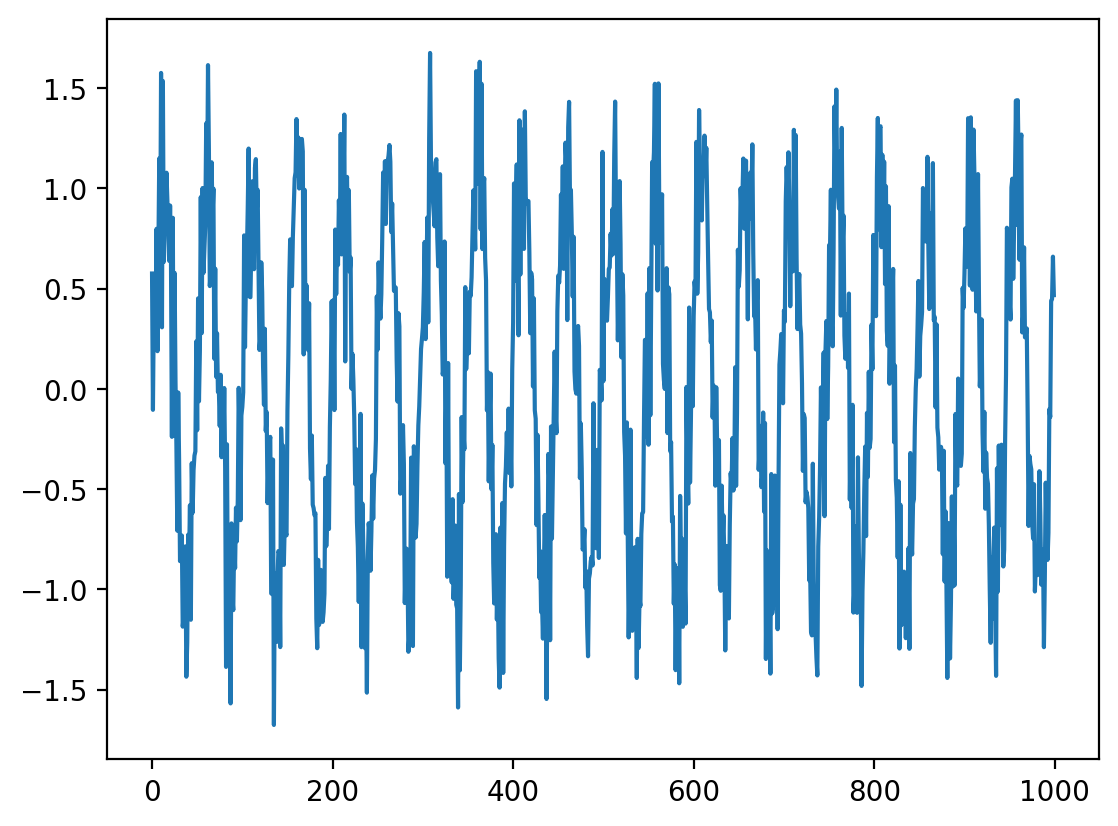

In [18]:
f0 = 201
#change to 201
fs = 10000
T = 3
Ns = fs*T

#def buffer(input_data, sample_rate, window_size, hop_size):
#sample_rate not use 
def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers.

This neural network is implemented in TensorFlow.

Please review the code cells below, and answer the questions that follow.

In [19]:
n_inputs = np.shape(xmat)[0]
n_hidden = 2

learning_rate = 0.01

X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
W = tf.Variable(tf.truncated_normal(stddev=.1, shape =[n_inputs,n_hidden]))

hidden = tf.matmul(X,W)
outputs = tf.matmul(hidden,tf.transpose(W))

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

/Users/ofirmachlof/.pyenv/versions/3.10.10/lib/python3.10/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


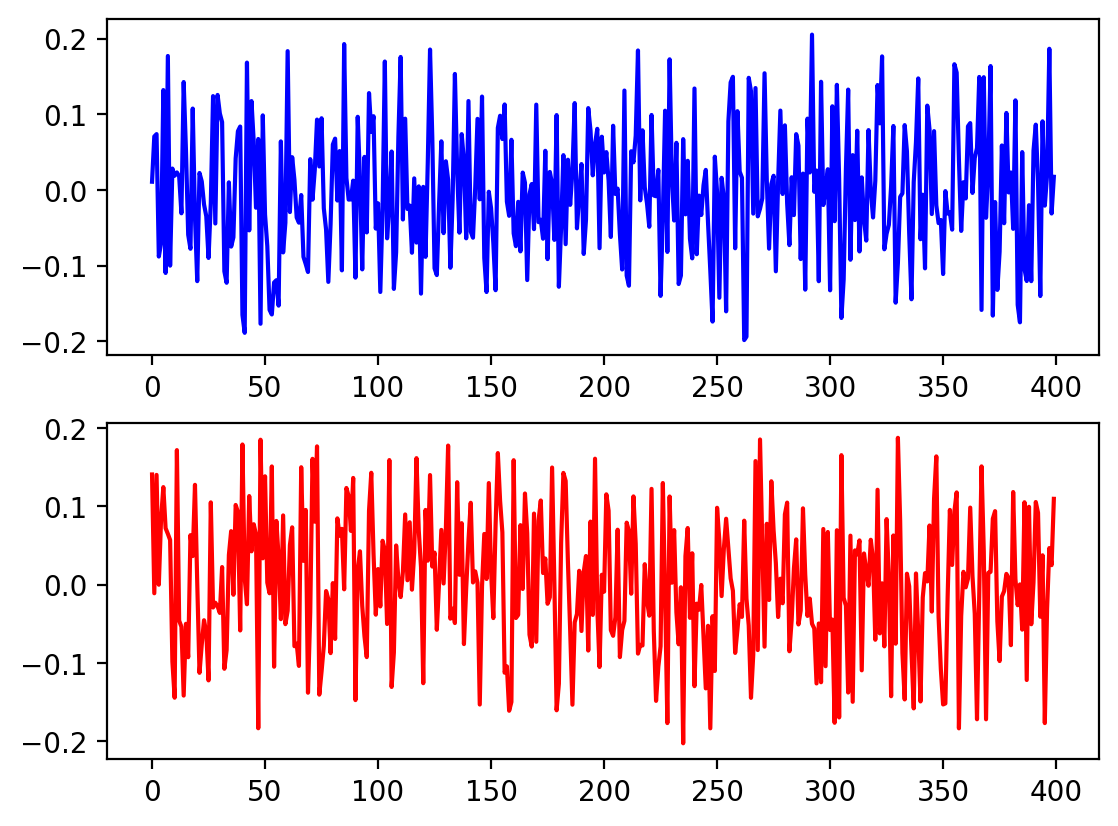

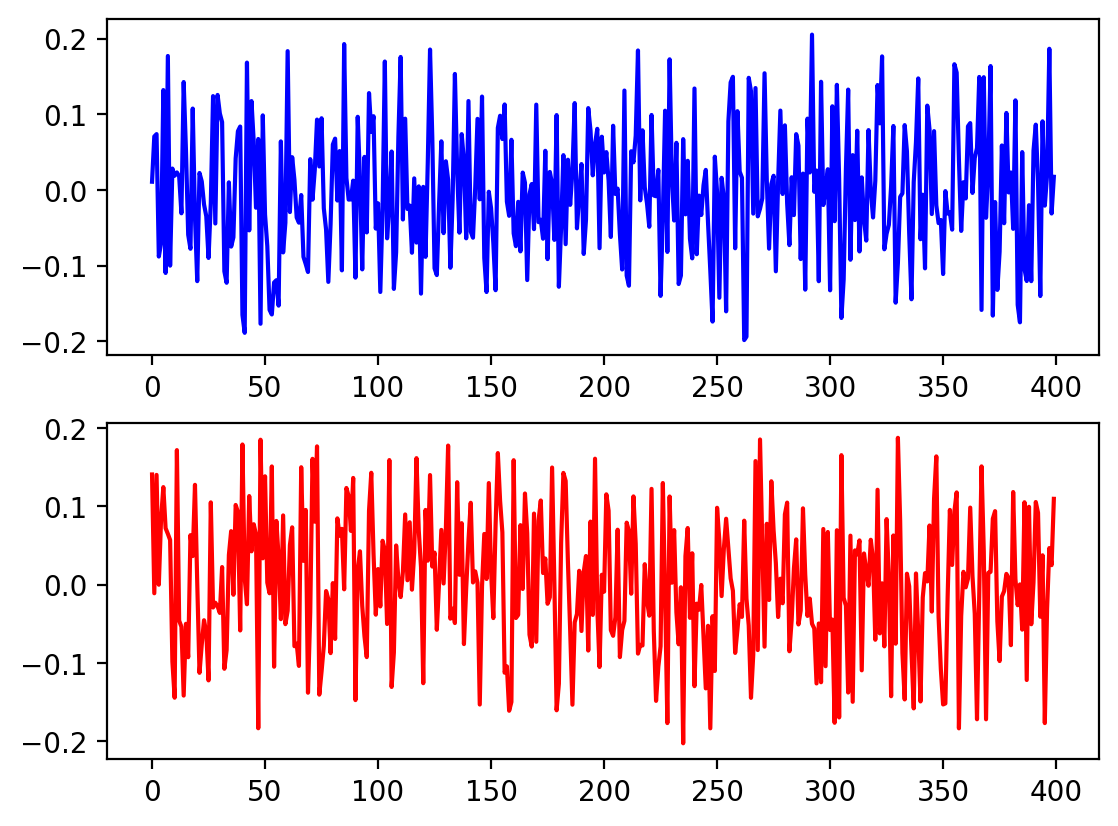

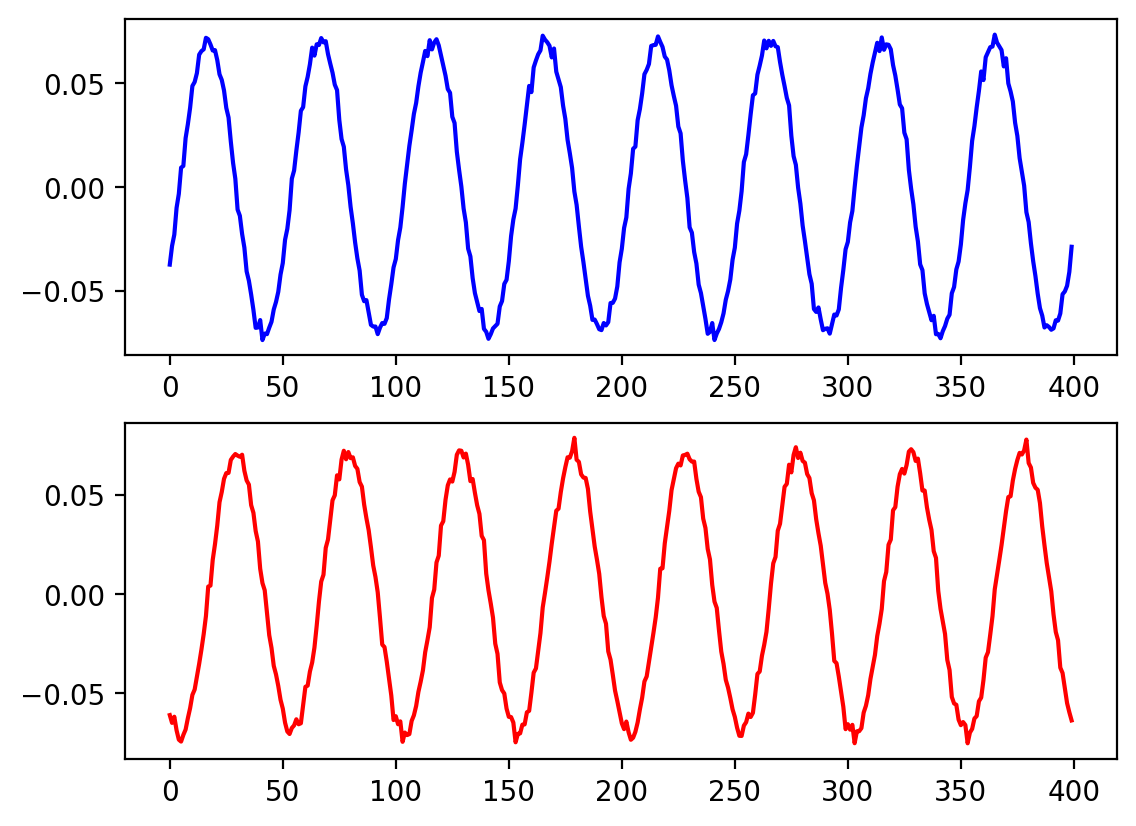

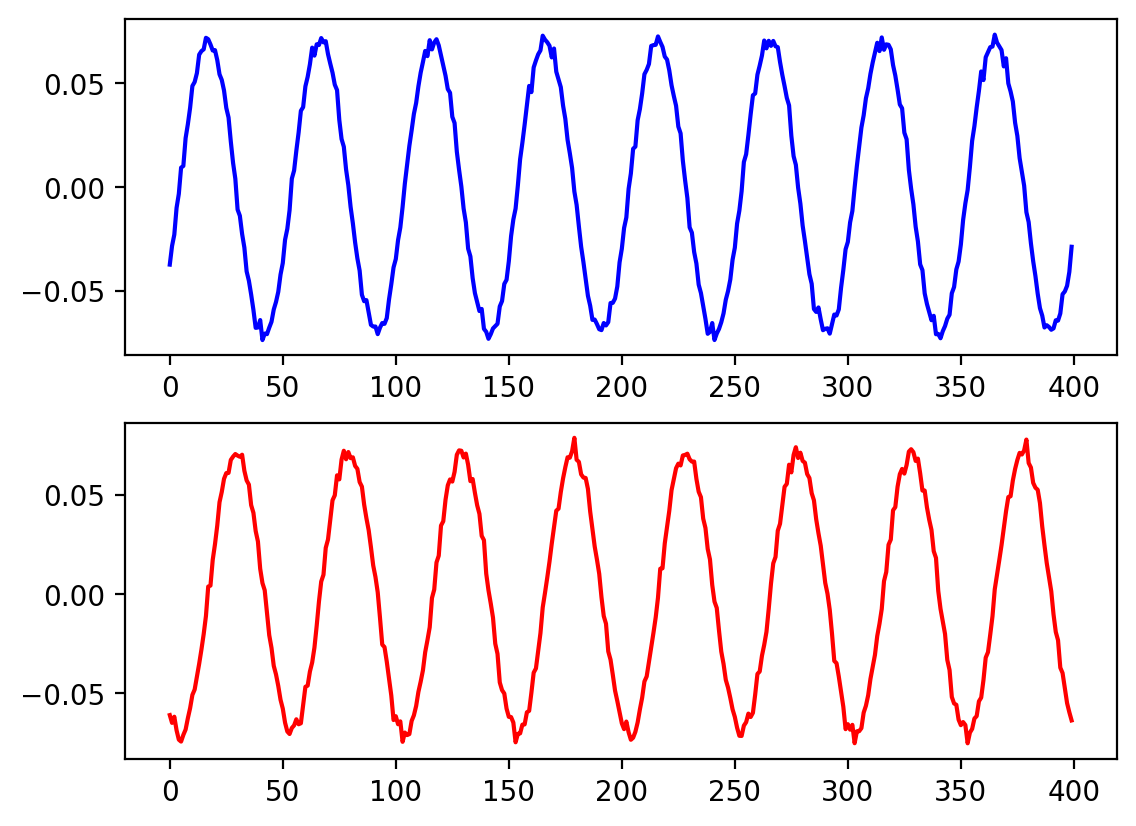

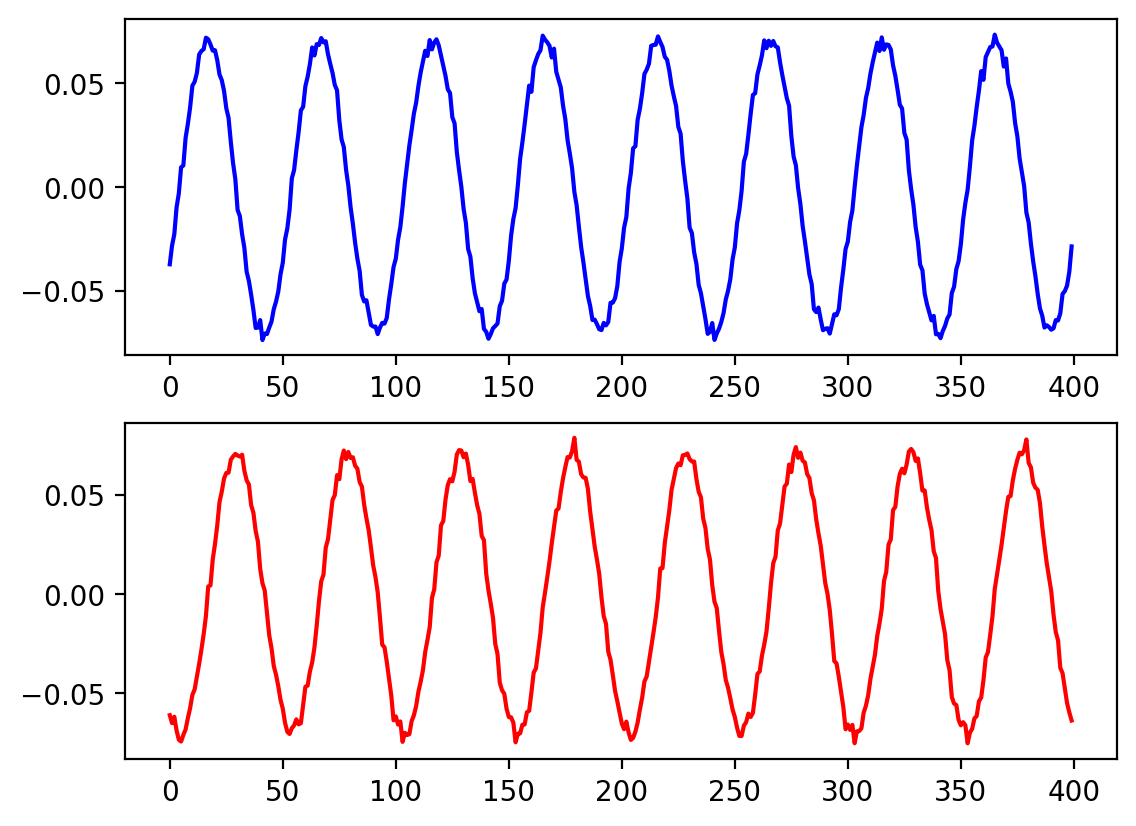

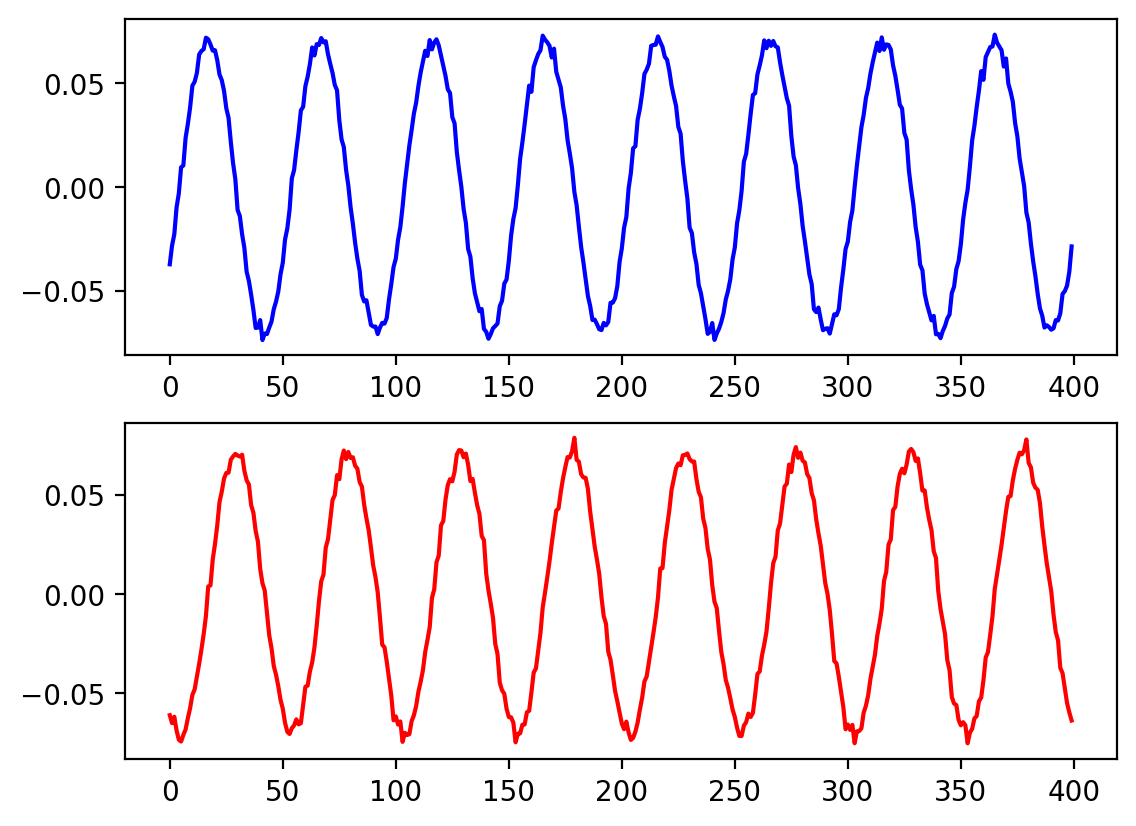

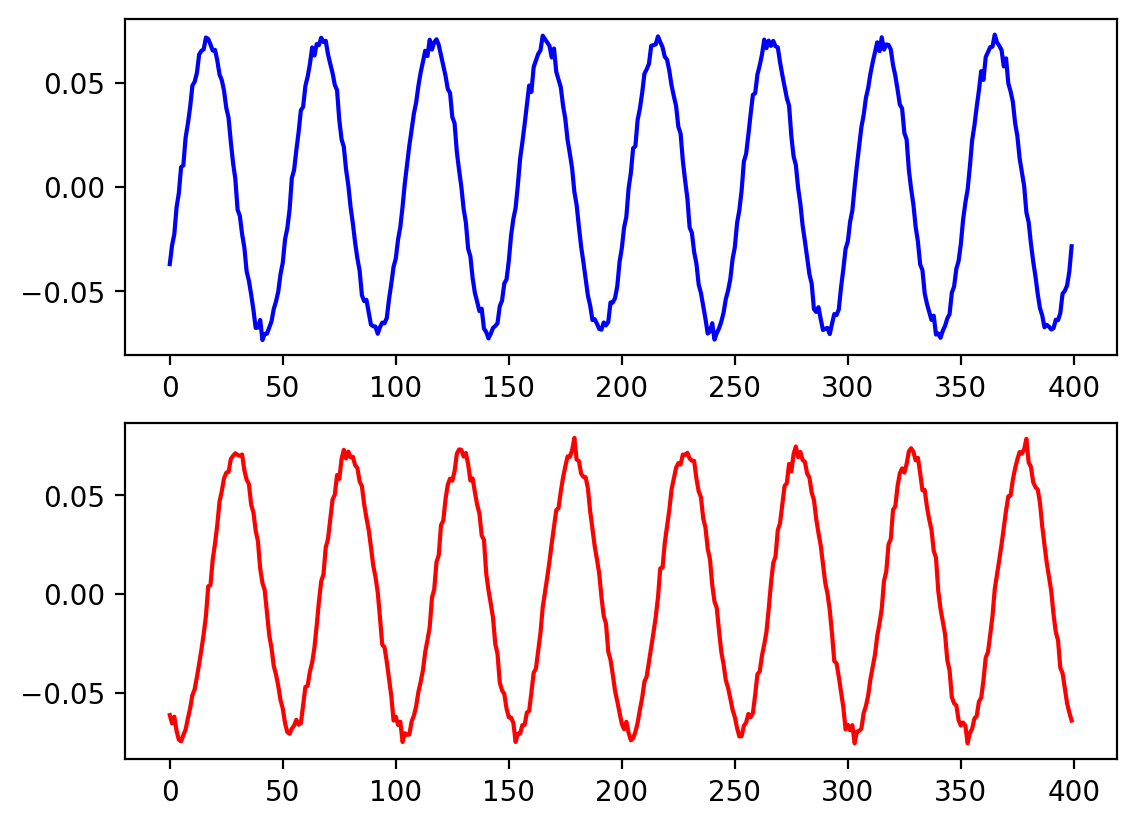

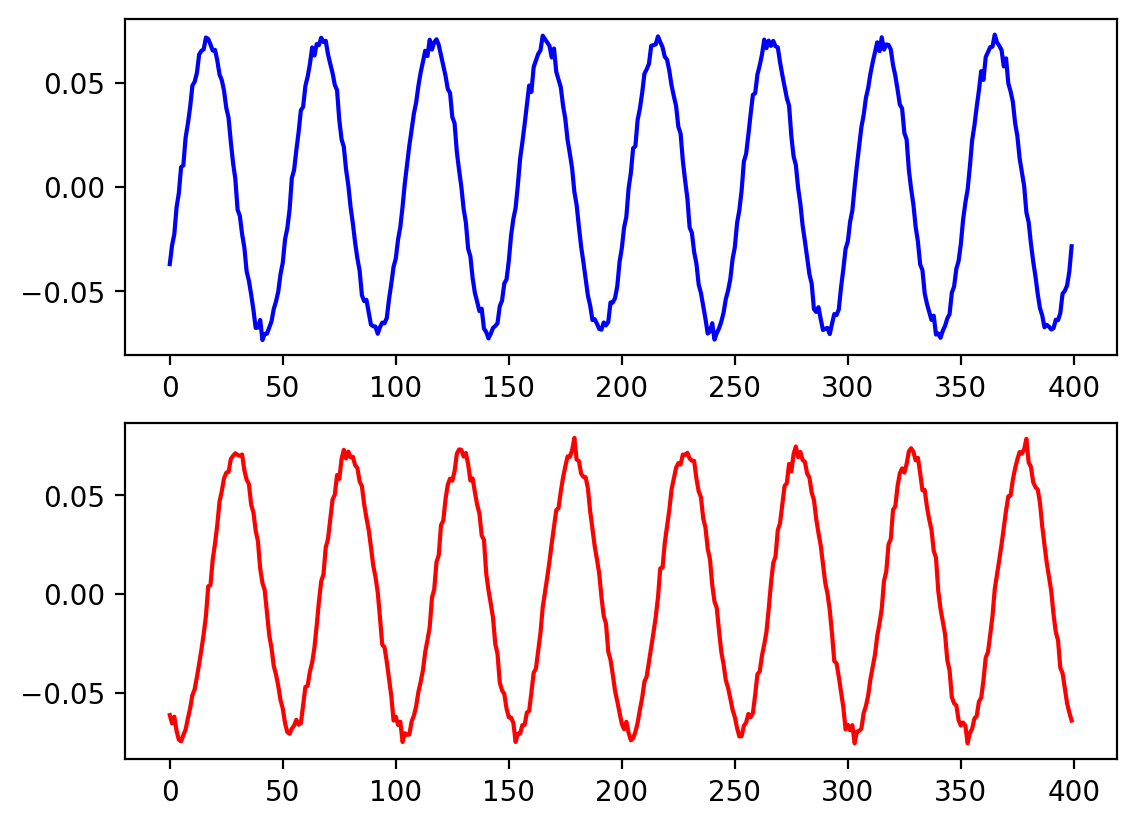

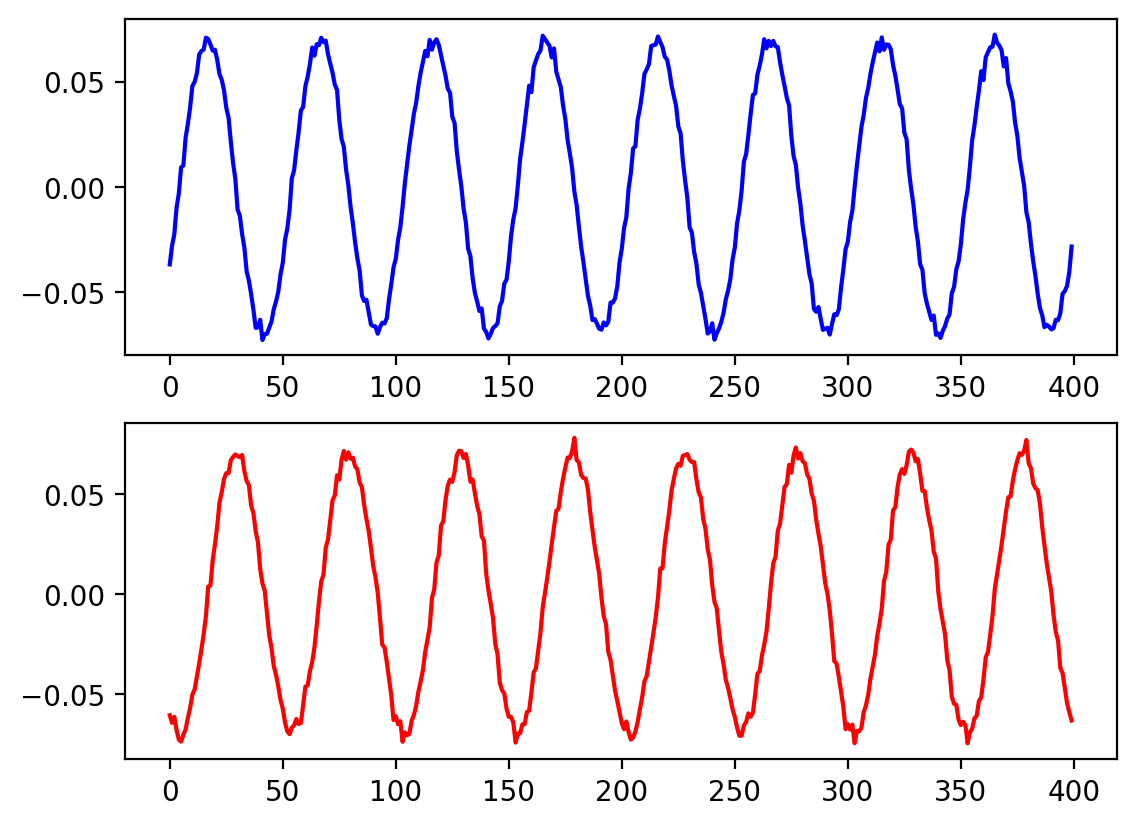

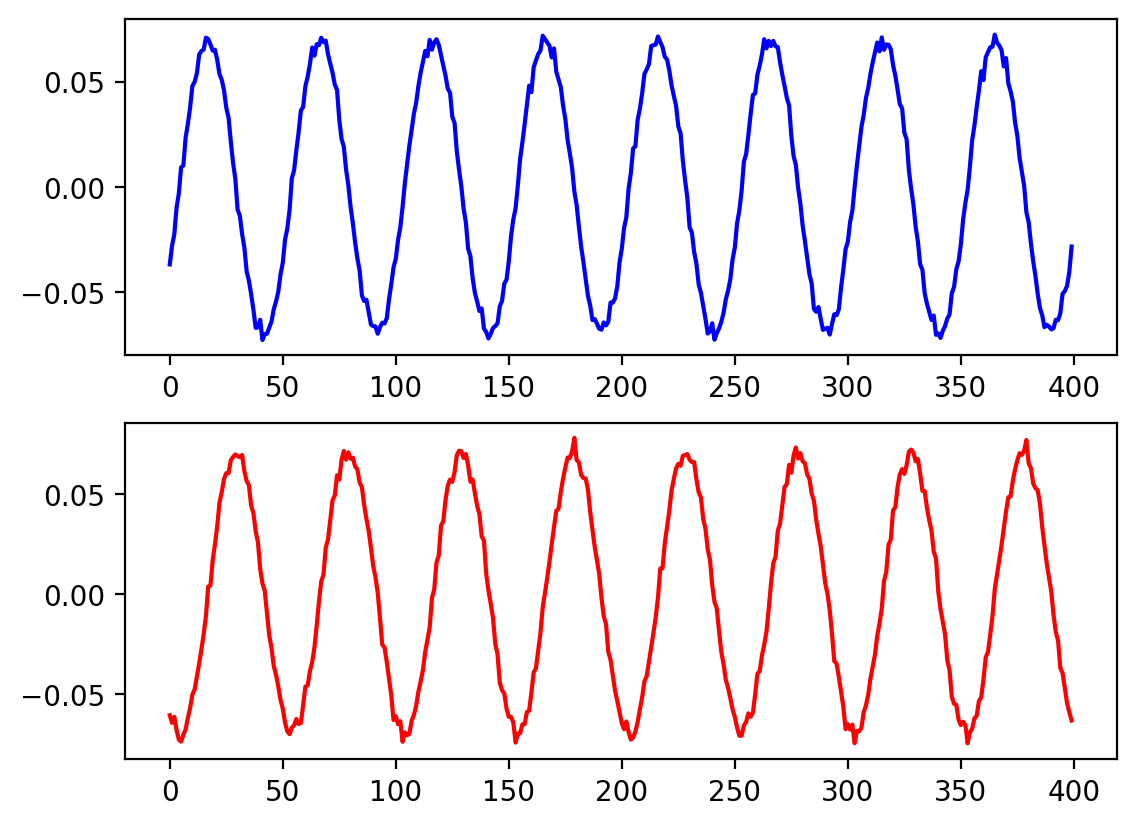

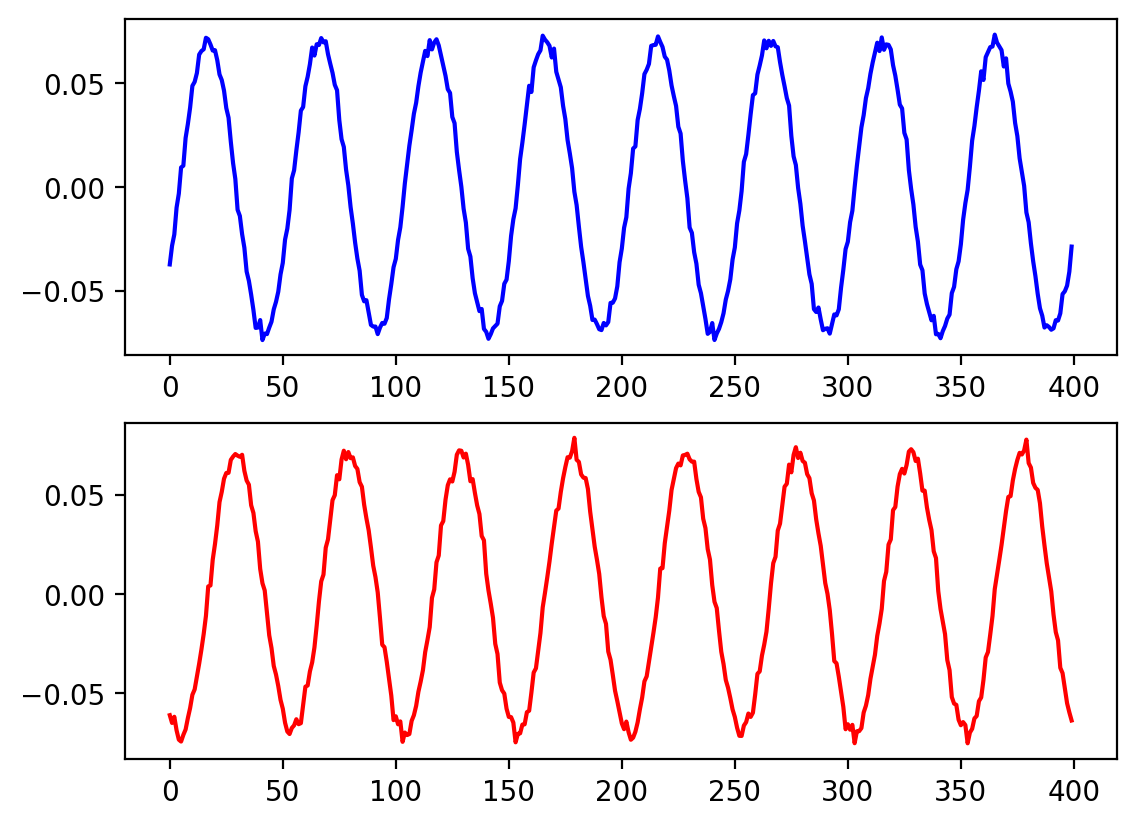

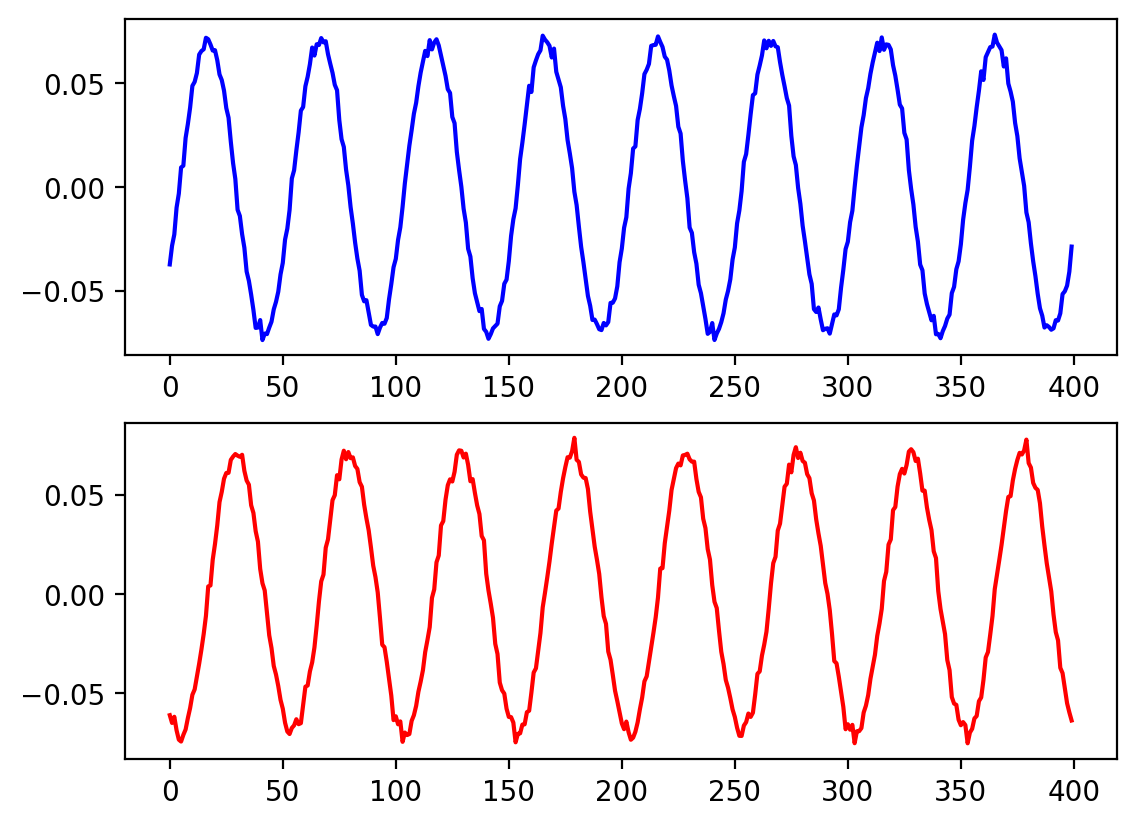

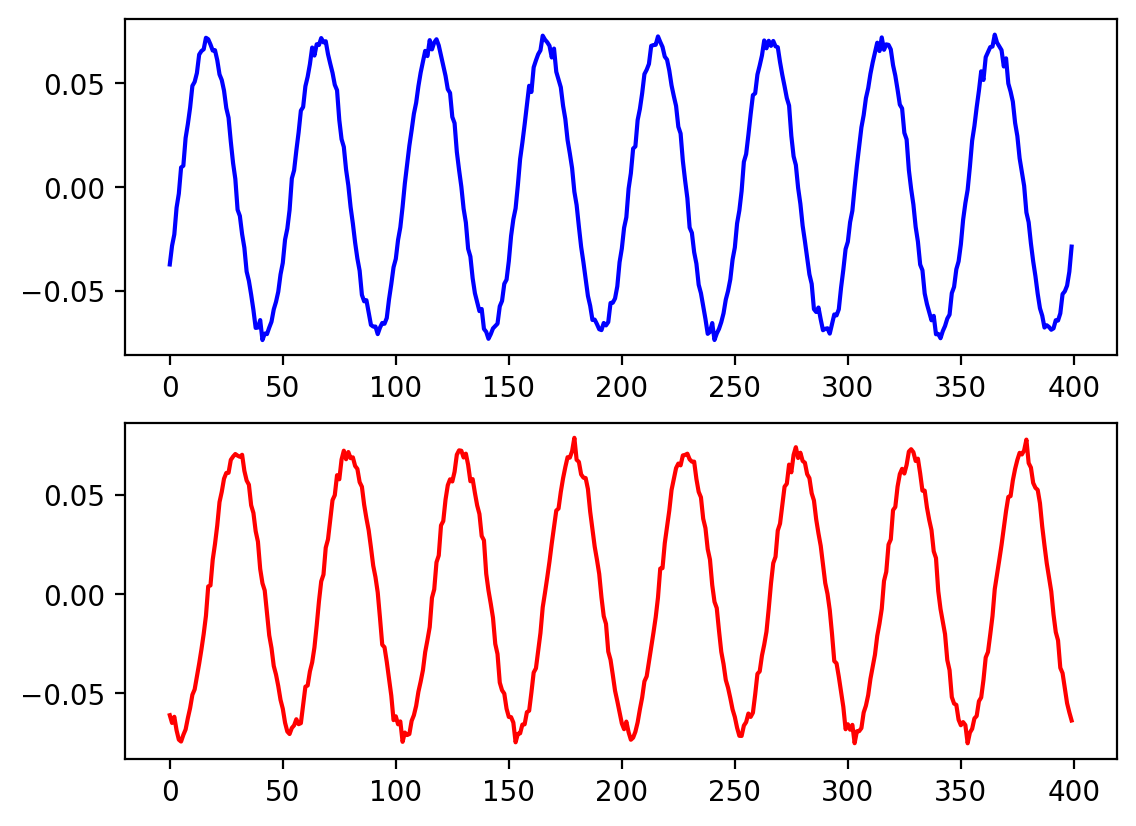

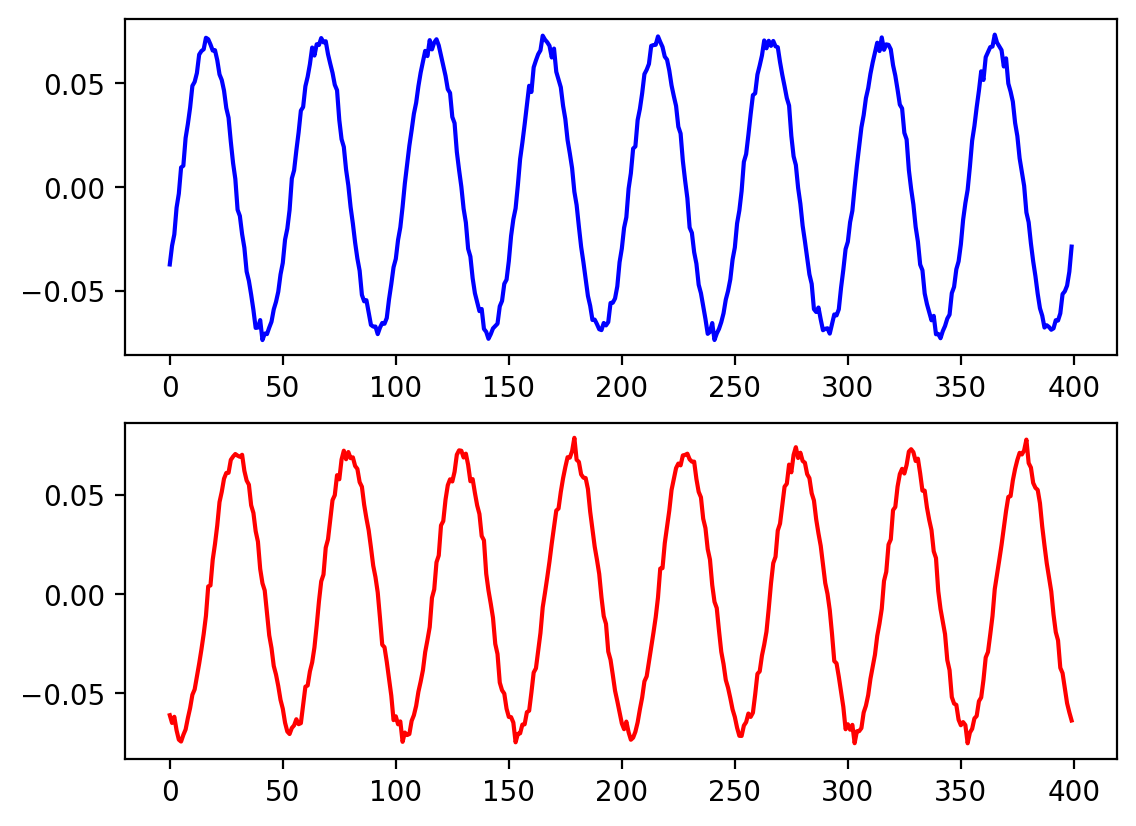

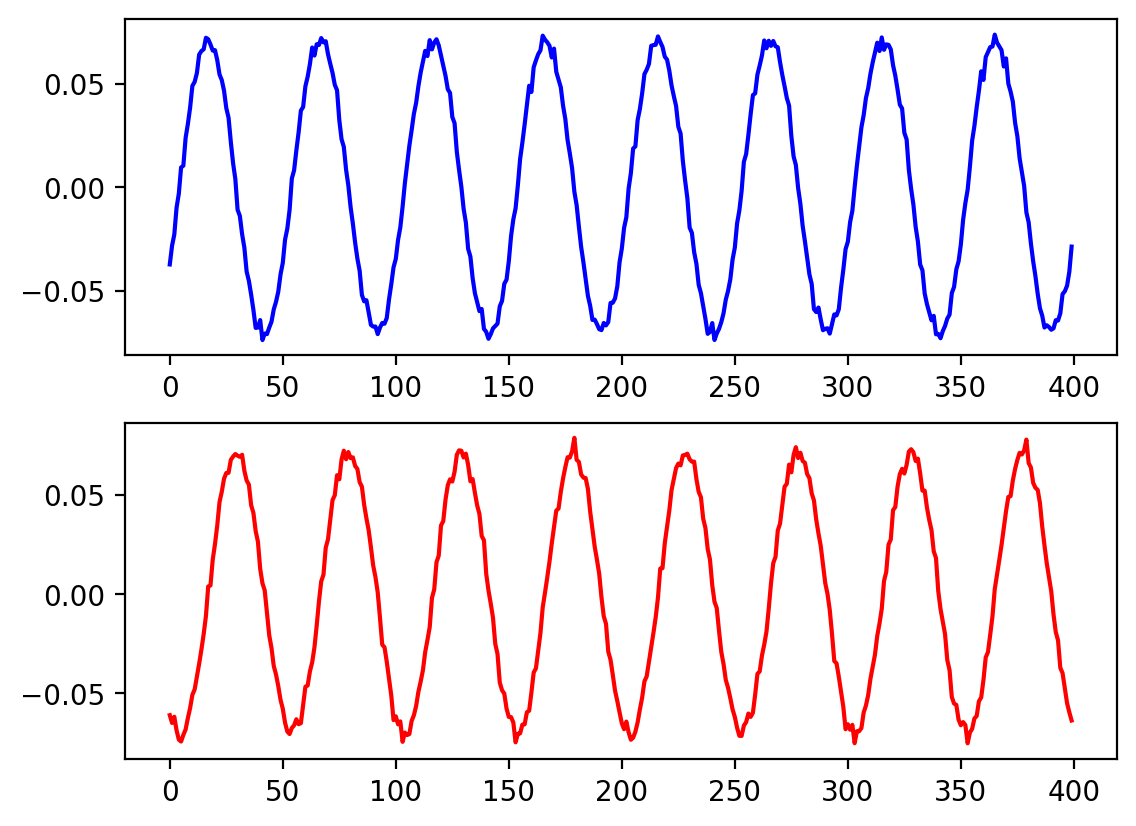

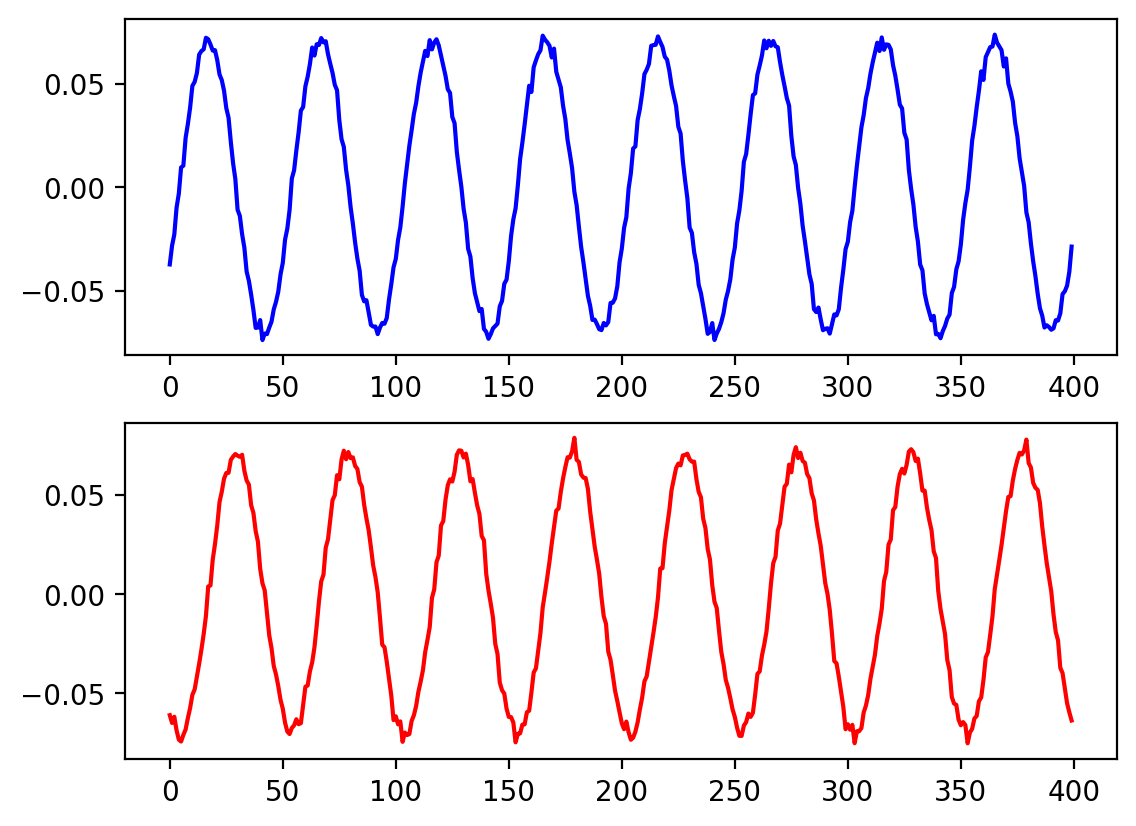

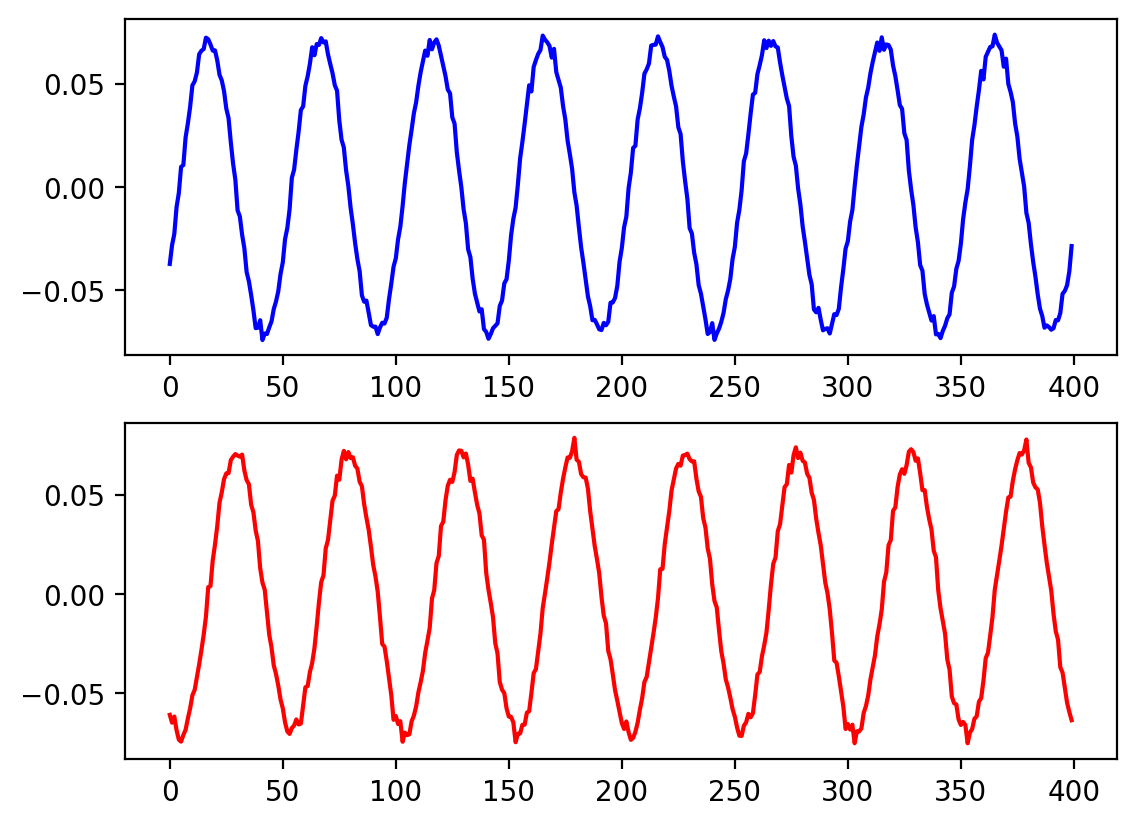

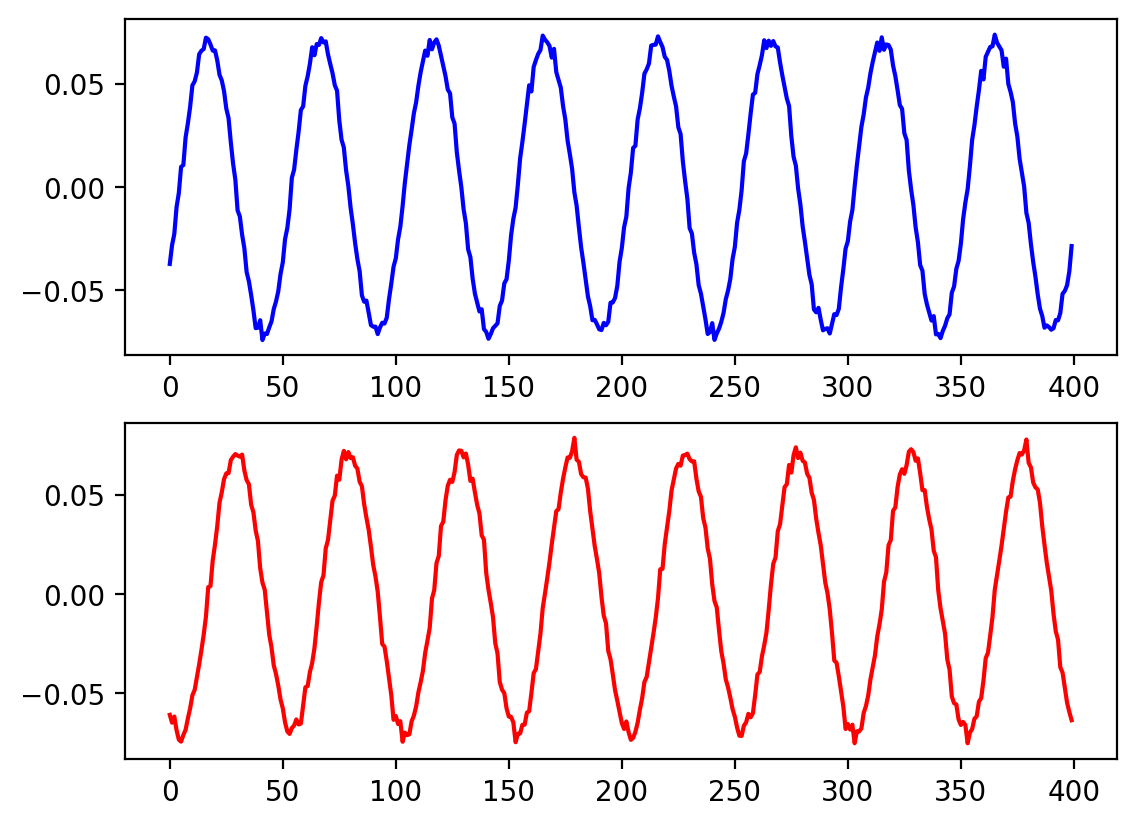

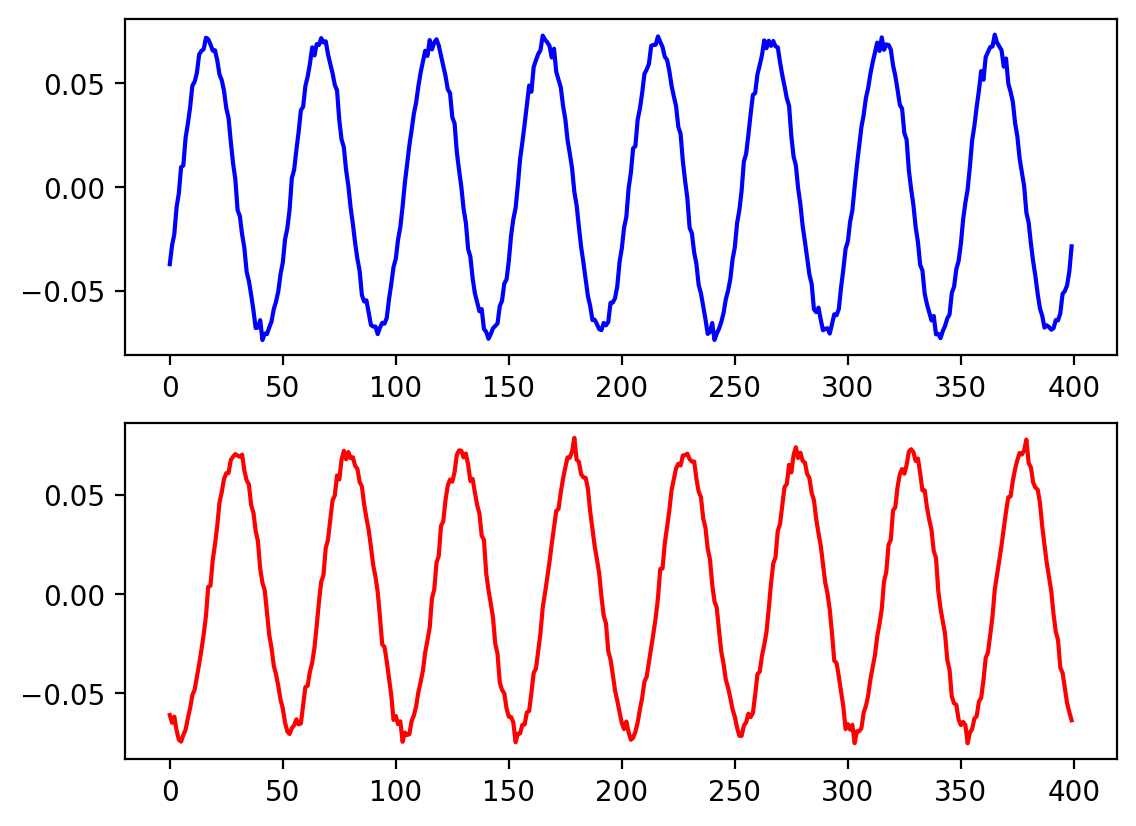

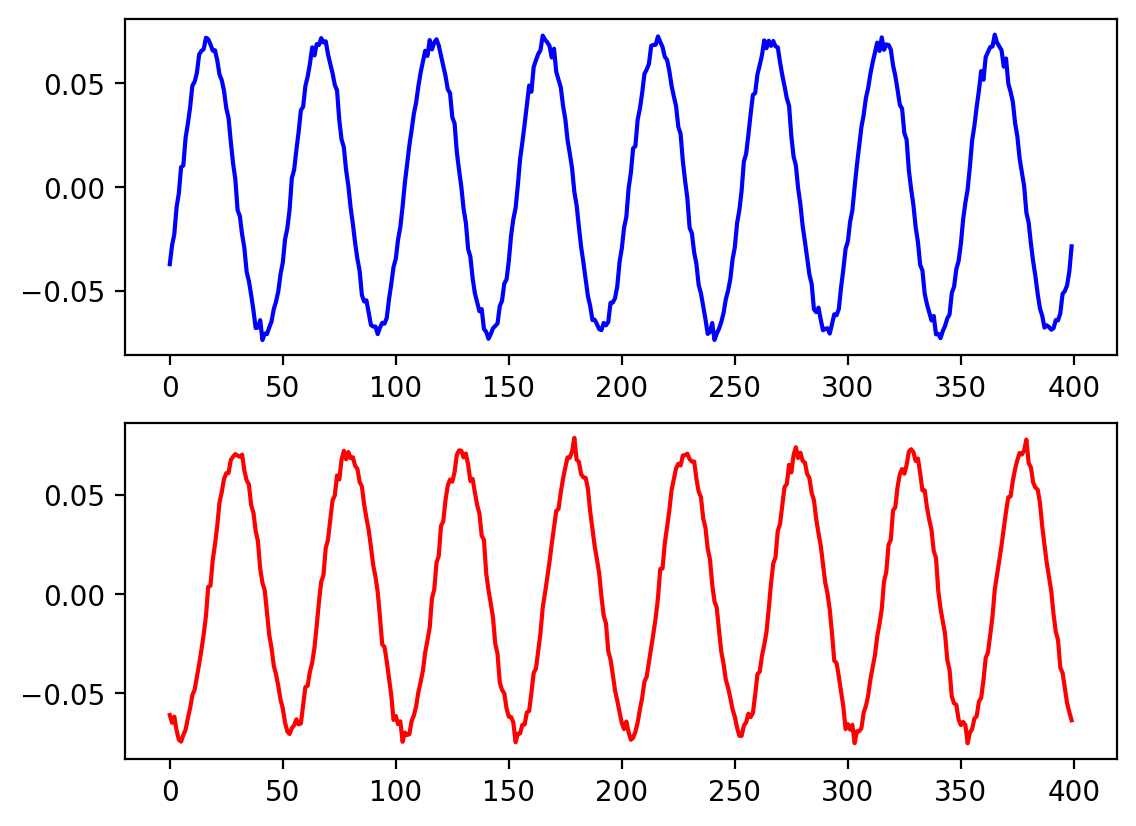

Done with training


In [20]:
n_iterations = 10000
codings = hidden
X_train = xmat.T
X_test = X_train

col = ['b','r','g','c','m','y','k']

sess = tf.InteractiveSession()
init.run()

for iteration in range(n_iterations):
    training_op.run(feed_dict={X: X_train})

    if iteration %1000 == 0:
        W_val = W.eval()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden,1,k+1)
            plt.plot(W_val[:,k],col[k % len(col)])
        plt.show(False)
        plt.pause(0.001)

codings_val = codings.eval(feed_dict={X: X_test})

print("Done with training")

##### Question 1 (20 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

An autoencoder is a type of neural network used in unsupervised learning, which focuses on learning a compressed representation of data. This process involves two main parts: encoding and decoding. Initially, the autoencoder learns to compress the input data into a lower-dimensional form (encoding), and then it learns to reconstruct the input data from this compressed form as accurately as possible (decoding). The primary goal of an autoencoder is to capture the most relevant features of the data while minimizing the impact of noise.

For a given signal x composed of various segments (e.g., `window_1, window_2, ..., window_n`), when processed through an autoencoder, the outcome is a series of reconstructed segments (`window_hat_1, window_hat_2, ..., window_hat_n`) that aim to closely mirror the original input segments.

In the scenario where only a specific segment of the signal x (e.g., `window_k`) is fed into the trained autoencoder, the network should ideally return a reconstructed version of that specific segment (`output=[window_hat_k]`). This outcome is anticipated because the autoencoder treats each segment of the signal independently, having learned to process and reconstruct individual segments based on the characteristics learned during training. Hence, passing a single segment or a portion of the signal through the autoencoder should yield a reconstruction of that specific portion, independent of other segments in the signal.

##### Question 2 (10 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

The variable `n_inputs` signifies the number of samples contained within a single window, specifically 400 samples. `X_train`, on the other hand, is a matrix with dimensions 149x400, where each row represents a single window of 400 samples. This structure arises because the original signal, composed of 30,000 samples, has been segmented into windows with a 50% overlap, equating to a hop size of 200 samples. As a result, the signal is divided into 149 such overlapping windows.

Therefore, in a single forward pass through the network, what is actually being passed to the input layer is not individual samples but rather batches of these windows, each containing 400 samples. During this process, each window is compressed into a more compact vector (typically of a much smaller size than the original 400 samples to achieve dimensionality reduction) and subsequently reconstructed to approximate the original window as closely as possible. In essence, for each forward pass, the network processes a batch of these 400-sample windows, aiming to learn an efficient encoding for them and then accurately reconstruct them from the encoded representation.

##### Question 3 (10 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

in this network the weights are denoted by the variable `W` for the encoder portion, and the decoder uses the transpose of `W`, represented as `W.T`, to facilitate the decoding process. 

Before the training process begins, these weights are initialized using a random values from a truncated normal distribution, centered around 0 with a standard deviation of 1. 

##### Question  4 (10 points)

What is being minimized in the reconstruction loss? Why is this helpful?

The reconstruction loss, minimized the mean squared error (MSE) of the AE. the loss function is minimizing the discrepancy between the input data fed into the autoencoder and the output data it generates after the decoding process.

This approach is helpful as it allows the network to be trained by minimizing the reconstruction error, which measures the discrepancies between our original input and the resulting reconstruction.
its helpful because it directly targets improving the fidelity of the reconstructed data relative to the original inputs.

##### Question 5 (10 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training?

Optimizers are algorithms or methods used to minimize an error function(loss function)or to maximize the efficiency of production. Optimizers are mathematical functions which are dependent on model’s learnable parameters i.e Weights & Biases. Optimizers help to know how to change weights and learning rate of neural network to reduce the losses.   [Optimizers in Deep Learning medium](https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0)

Three popular optimizers in machine learning and deep learning include:

1. Stochastic Gradient Descent (SGD): A foundational optimizer that updates parameters using a predetermined small quantity called the learning rate, applied to the gradient of the loss function. Despite its simplicity, SGD is effective for a wide range of problems, though it may require careful tuning of the learning rate and can be slow to converge.

2. Adam (Adaptive Moment Estimation): An advanced optimizer that combines the benefits of two other extensions of SGD, AdaGrad and RMSProp, by computing adaptive learning rates for each parameter. Adam stores an exponentially decaying average of past squared gradients and also keeps an exponentially decaying average of past gradients, making it well-suited for problems with large datasets or parameters.

3. RMSprop (Root Mean Square Propagation): This optimizer modifies SGD by dividing the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight. This can lead to faster convergence compared to traditional SGD, especially in the context of neural networks with noisy or sparse gradients.

For the training of the autoencoder (AE) described, the Adam optimizer is utilized. 

We can examine now the "codings", i.e. the hidden unit values and their distribution. The more significant codings should have smaller variances.

mean:  [-0.21251893  0.04456626]
variance [10.003166 10.02431 ]


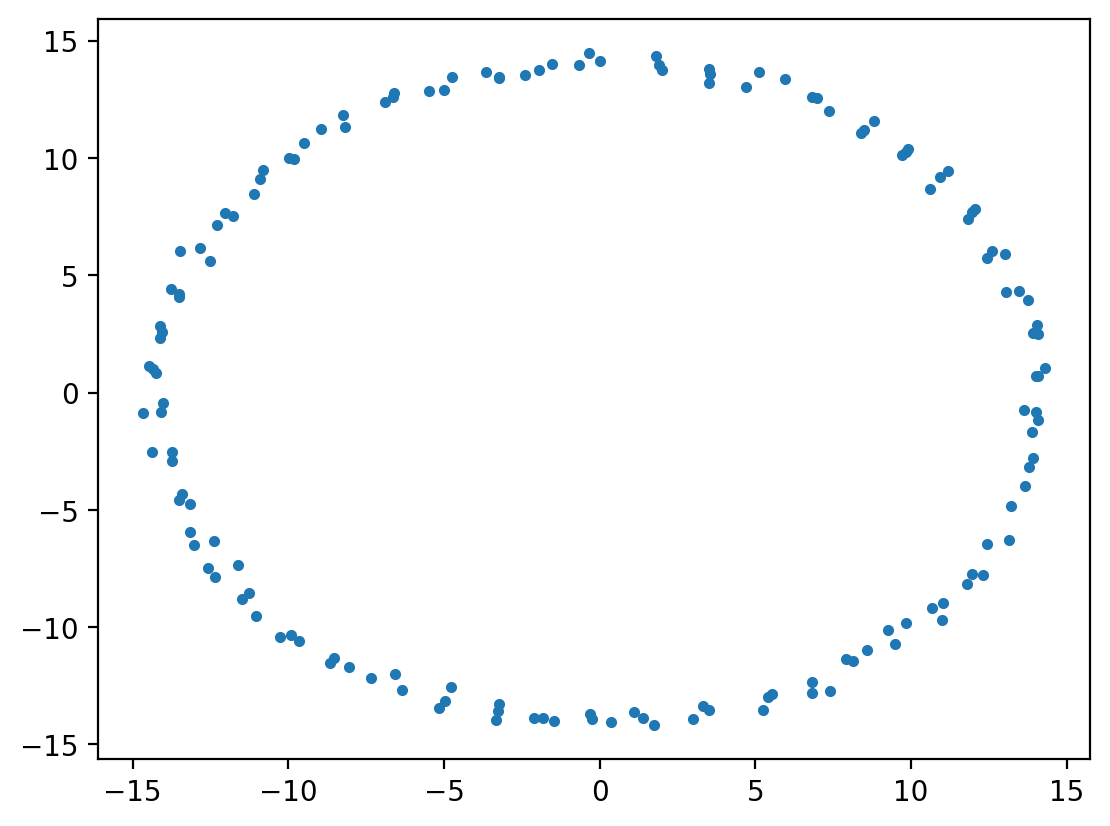

In [21]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))
#change f0 = 201 otherwise the graph not distributing nice

###### Question 6 (10 points)

In what way does the autoencoder network function similarly to PCA?

Autoencoders and Principal Component Analysis (PCA) share the common goal of dimensionality reduction, aiming to simplify the complexity of datasets while retaining as much original information as possible. Both methods achieve this by identifying and leveraging the intrinsic patterns within the data to find a more compact, lower-dimensional representation.

The similarity between autoencoders and PCA particularly emerges when the autoencoder is restricted to linear activations. In such a configuration, the autoencoder essentially learns a linear transformation of the input data, akin to how PCA identifies the principal components of the data. This linear version of an autoencoder can be seen as performing a similar mathematical operation to PCA, where the original high-dimensional data (e.g., a 400-dimensional vector) is projected onto a lower-dimensional space (e.g., a 2-dimensional vector) through a learned transformation matrix (denoted as `W`). The process then reverses, using the transpose of this matrix (`W.T`) to reconstruct the data back into its original high-dimensional space, attempting to approximate the original input as closely as possible.

In essence, when employing linear activations, an autoencoder mirrors the PCA process by learning to encode the data into a reduced set of dimensions that captures its most significant variance, before reconstructing it. This parallels PCA's extraction of principal components, which represent the directions of maximum variance in the data. However, unlike PCA which is strictly linear, autoencoders can incorporate non-linear transformations through non-linear activations, offering a more flexible approach to capturing complex patterns in data beyond what linear methods like PCA can achieve.

##### Question 7 - PCA versus AE (30 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network?


In this code, `X_train` and `X_test` represent the dataset's training and test splits, respectively, while `ae_reconstruction` is the reconstructed output from the autoencoder for comparison. The PCA's explained variance ratio indicates how much of the total dataset variance is captured by the two principal components, providing insight into the effectiveness of the PCA dimensionality reduction relative to the autoencoder's performance. By comparing the original sample to its reconstructions, we can assess the fidelity of each method's dimensionality reduction and reconstruction capabilities.

In [22]:
ae_reconstruction = outputs.eval(feed_dict={hidden: codings_val})

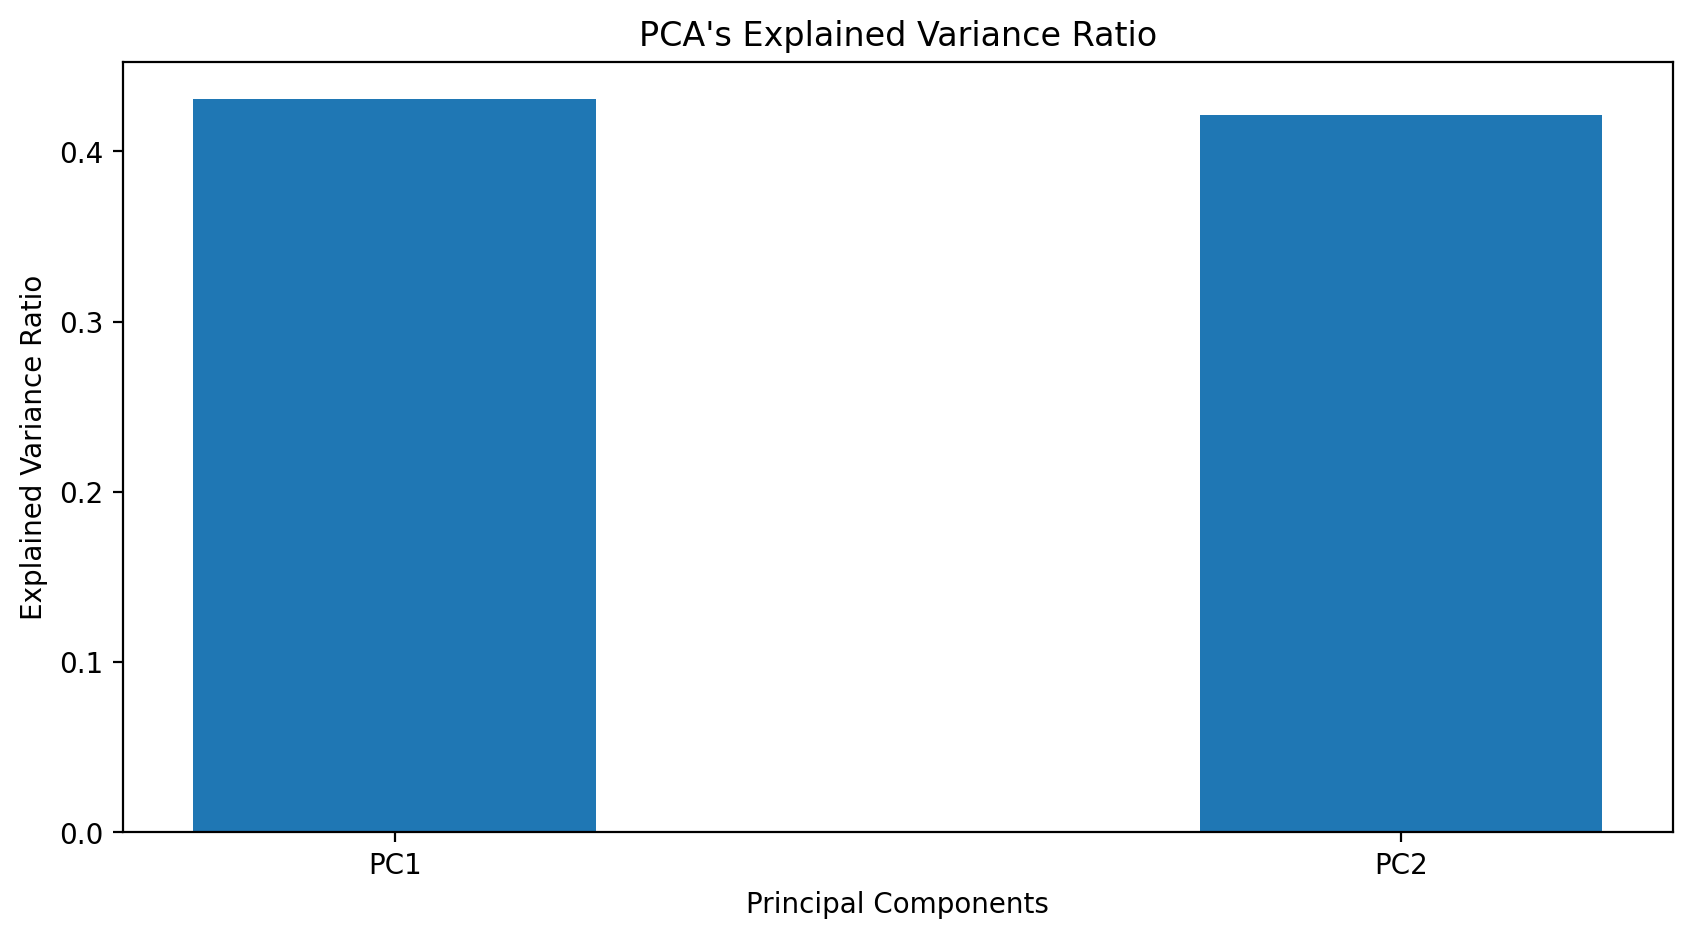

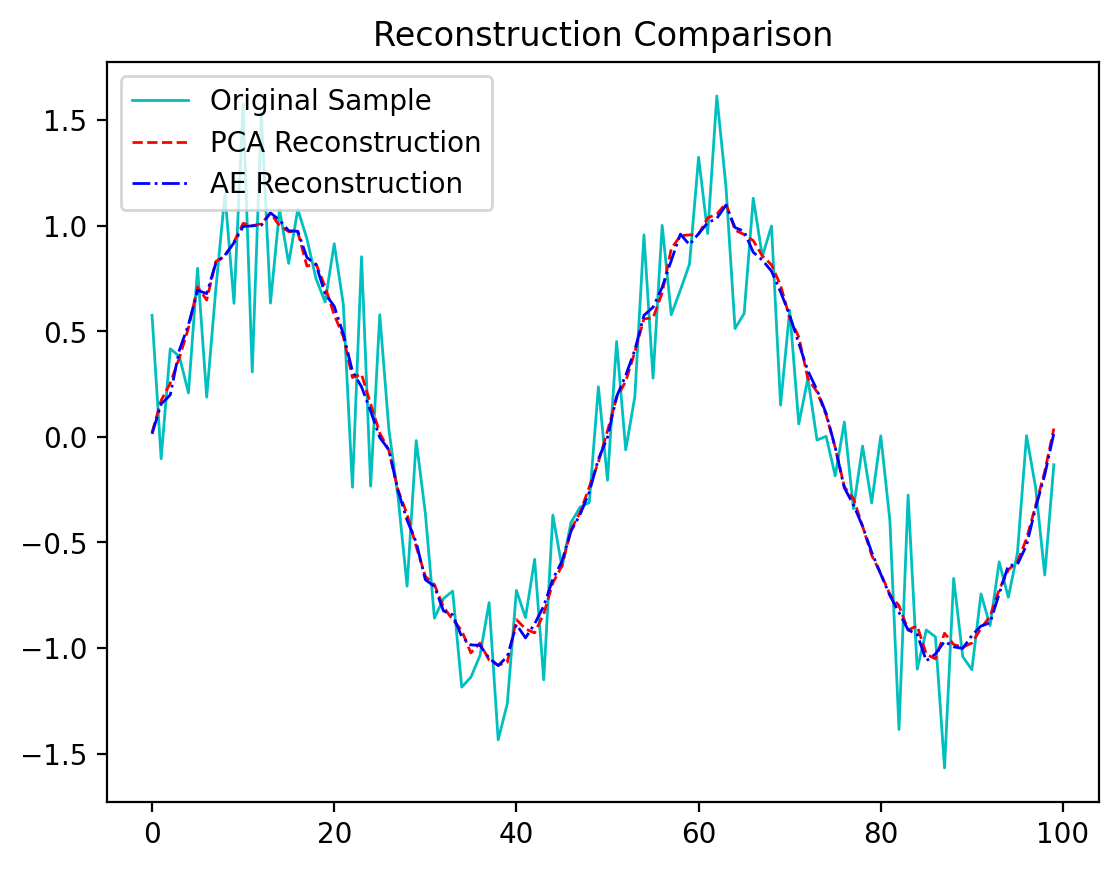

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, X_test are defined, and ae_reconstruction is available

n_pc = 2  # Number of principal components

# Initialize PCA and transform the data
pca = PCA(n_components=n_pc)
X_train_pc = pca.fit_transform(X_train)
X_test_pc = pca.transform(X_test)

# Reconstruct the test data from the principal components
pca_reconstruction = pca.inverse_transform(X_test_pc)

# Visualize the explained variance ratio
plt.figure(figsize=(10, 5))
plt.bar(['PC1', 'PC2'], pca.explained_variance_ratio_, width=0.4)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA's Explained Variance Ratio")
plt.show()

# Comparison of original, PCA, and AE reconstruction for the first 100 samples of the first test sample
fig, ax = plt.subplots()
ax.plot(X_test[0][:100], 'c-', label="Original Sample", linewidth=1)
ax.plot(pca_reconstruction[0][:100], 'r--', label="PCA Reconstruction", linewidth=1)
ax.plot(ae_reconstruction[0][:100], 'b-.', label="AE Reconstruction", linewidth=1)
ax.legend()
ax.set_title("Reconstruction Comparison")
plt.show()
